# Assessing Model #1
[credit: cases are from Berkeley [data8](https://data8.0rg)]

In data science, a model in data science is a structured way to map inputs (features) to outputs (predictions or explanations) using learned parameters and explicit assumptions about how data is generated. 

In practice, we must judge whether a model is any good. This section introduces the principles of model evaluation through a concrete example, showing how to assess fit, compare alternatives, and decide if a model is suitable for the task.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

## Case 1: Swain vs. Alabama

In the early 1960s in Talladega County, Alabama, Robert Swain, a Black man, was convicted of raping a white woman and sentenced to death. He appealed, arguing—among other issues—that the jury process was discriminatory. At that time, only men aged 21 and older were eligible for jury service. Although 26% of the county’s eligible jurors were Black, the 100-person jury panel for Swain’s case included only 8 Black men (8%), and none were seated on the trial jury. In 1965, the U.S. Supreme Court denied Swain’s appeal, stating that “the overall percentage disparity has been small.” 

Because jury panels are intended to be random samples from the eligible population, the key statistical question is whether observing 8% Black on a 100-person panel is a plausible outcome if the true eligible population is 26% Black, or whether the shortfall is unlikely to be due to chance alone.

## Model to Evaluate

One way to interpret the data — a **statistical model** —is that the jury panel was formed by **random selection**, and the low count of Black men arose purely by chance. This view aligns with the Supreme Court’s characterization.

To make that model precise, we specify the chance mechanism: treat the panel as a random sample from an eligible population in which 26% of individuals are Black. This is testable **computationally**:

- **Simulate** under the model: repeatedly draw panels of 100 from a population with 26% Black.
- Characterize expected outcomes: record how many Black panelists appear in each **simulated panel**.
- Compared to the **observed** panel, Swain’s panel had 8% Black (8 of 100).
- Evaluate **consistency**: if results like “8 of 100” are rare under the model, that is evidence against random selection from a 26% population.

We now walk through this assessment step by step.

## Choosing a Test Statistic

We must select a statistic that helps distinguish the **model** (random selection from the eligible population) from the **alternative** (that the panel included too few Black members to be random). A natural choice is the **count** of Black panelists in the **100**-person panel. Under this choice, smaller counts provide evidence against the random-selection model and in favor of Swain’s claim.

## Predicting the Statistic Under the Model

If the model were true, how big would the statistic typically be? To answer that, we have to start by working out the details of the simulation.

### Generating One Value of the Statistic¶
First let’s figure out how to simulate one value of the statistic. For this, we have to sample 100 times at random from the population of eligible jurors and count the number of black men we get.

One way is to set up a table representing the eligible population and use a sample as we did in the previous chapter. But there is also a quicker way; we can build a function tailored for sampling at random from categorical distributions. We will use this function, **`sample_proportions`**. The sample_proportions function will take two arguments:

- the sample size
- the distribution of the categories in the population, as a list or array of proportions that add up to 1

As the function uses a numpy ‘method’ an array will be returned containing the distribution of the categories in a random sample of the given size taken from the population. This is an array consisting of the sample proportions in all the different categories.

To see how to use this, remember that according to our model, the panel is selected at random from a population of men among whom 26% were black and 74% were not. Thus, the distribution of the two categories can be represented as the list [0.26, 0.74], which we have assigned to the name eligible_population. Now let’s sample at random 100 times from this distribution, and see what proportions of the two categories we get in our sample.

```{note}
The multinomial distribution is a multivariate generalization of the
binomial distribution. Take an experiment with one of `p`
possible outcomes.  An example of such an experiment is throwing a dice,
where the outcome can be 1 through 6. Each sample drawn from the
distribution represents `n` such experiments.  Its values, `X_i = [X_0, X_1, ..., X_p]`, represent the number of times the outcome was `i`. (from Shif+Tab)
```

In [47]:
### e.g., test multinomial

np.random.multinomial(100, [0.26, .74])

array([24, 76])

In [3]:
np.random.seed(42)
def sample_proportions(sample_size, probabilities):
    """Return the proportion of random draws for each outcome in a distribution.
    This function is similar to np.random.multinomial, but returns proportions
    instead of counts.
    Args:
        ``sample_size``: The size of the sample to draw from the distribution.
        ``probabilities``: An array of probabilities that forms a distribution.
    Returns:
        An array with the same length as ``probability`` that sums to 1.
    """
    return np.random.multinomial(sample_size, probabilities) / sample_size
    # return np.random.multinomial(sample_size, probabilities) 

In [54]:
eligible_population = [0.26, 0.74]
sample_proportions(100, eligible_population)

array([0.23, 0.77])

The proportion of black men in the random sample is item(0) of the output array.

Because there are 100 men in the sample, the number of men in each category is 100 times the proportion. So we can just as easily simulate counts instead of proportions, and access the count of black men only.

Run the cell a few times to see how the output varies.

In [67]:
### count of black men in a simulated panel

# (100 * sample_proportions(100, eligible_population)).item(0)
print((100 * sample_proportions(100, eligible_population))[0])

17.0


## Running the Simulation
To get a sense of the variability without running the cell over and over, let’s generate 10,000 simulated values of the count. You can think of that as you did 10,000 times of data collection.

The code follows the same steps that we have used in every simulation. First, we define a function to simulate one value of the count, using the code we wrote above.

Let's define a function that does this. The function will draw a panel at random and return the number of panelists who are Black.

In [68]:
np.random.seed(42)

sample_size = 100

def one_simulated_count():
    # return sample_size * sample_proportions(sample_size, eligible_population).item(0)
    return sample_size * sample_proportions(sample_size, eligible_population)[0]

Next, we create an array of 10,000 simulated counts by using a for loop.



In [69]:
np.random.seed(42)

counts = np.array([])
repetitions = 10000                 ### n
for i in np.arange(repetitions):
    counts = np.append(counts, one_simulated_count())

In [70]:
counts

array([25., 33., 29., ..., 33., 25., 23.], shape=(10000,))

We can also check the **min** and **max** of the data to get some idea about **bins**. 

In [71]:
print(counts.min(), counts.max())

9.0 42.0


## The Prediction
To interpret the results of our simulation, we can visualize the results in an **empirical** histogram of the simulated counts.

/var/folders/g4/v24tl8t172g5d7rzsd63y51w0000gp/T/ipykernel_76819/3934956901.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:g}'.format( x * 100) for x in y_vals ])  ### list comprehension


(-0.002, 0.095)

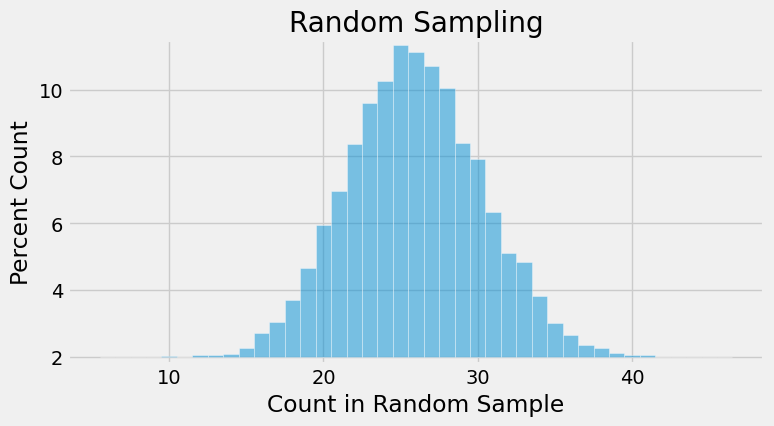

In [77]:
df = pd.DataFrame({
    'Count in a Random Sample': counts
})

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(df, bins = np.arange(5.5, 46.6, 1), alpha=0.5, density=True, ec='white')     ### density == y-ticks (increment!)
y_vals = ax.get_yticks()
ax.set_yticklabels(['{:g}'.format( x * 100) for x in y_vals ])  ### list comprehension
ax.set_title('Random Sampling')
ax.set_xlabel('Count in Random Sample')
ax.set_ylabel('Percent Count')

plt.ylim(-0.002, 0.095)

### other options
# Option A: PercentFormatter (xmax=1 for densities)
# from matplotlib.ticker import PercentFormatter, FuncFormatter
# ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
# Option B: custom, if you want no decimals
# ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y*100:.0f}%'))

The histogram shows us what the model of random selection predicts about our statistic, the number of Black panelists in the sample.

To generate each simulated count, we drew 100 times at random from a population in which 26% were Black. So, as you would expect, most of the simulated counts are around **26**. They are not exactly 26: there is some variation. The counts look like they range from about **12** to about **42**. Although we know that the minimum is **9**, from the graph, we can't really tell, although we have a good guess. We also know that if we did not set the random seed, the `min()` and `max()` will vary a little every time. 

## Comparing the Prediction and the Data ##
In the panel selected for the trial, there were eight Black panelists. The histogram of simulated counts is redrawn below with value **eight** shown as a **red dot** on the horizontal axis. The dot is very far out in the left hand tail of the histogram. Very few of the 10,000 counts simulated by random selection came out to be eight or less. 

/var/folders/g4/v24tl8t172g5d7rzsd63y51w0000gp/T/ipykernel_76819/3110690127.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:g}'.format( x * 100) for x in y_vals ])  ### list comprehension


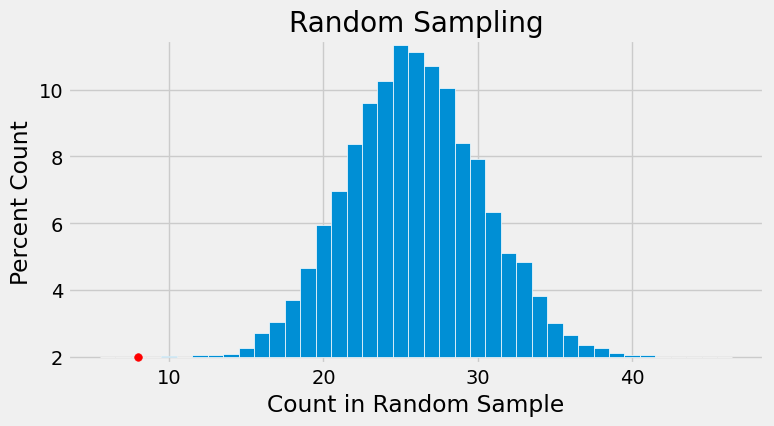

In [78]:
### redraw the histgram

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(df, bins = np.arange(5.5, 46.6, 1), 
        density=True, ec='white')     ### density == y-ticks (increment!)

y_vals = ax.get_yticks()
ax.set_yticklabels(['{:g}'.format( x * 100) for x in y_vals ])  ### list comprehension
ax.set_title('Random Sampling')
ax.set_xlabel('Count in Random Sample')
ax.set_ylabel('Percent Count')
plt.ylim(-0.002, 0.095)

### draw the 8 percent 
plt.scatter(8, 0, color='red', s=30)

## Conclusion of the Data Analysis

The graph above is a visual display of bias in the selection process. It shows that if we select a panel of size 100 at random from the eligible population, we are very unlikely to get counts of Black panelists that are as low as the eight that were observed on the panel in the trial. 

This is evidence that the model of random selection of the jurors in the panel is not consistent with the data from the panel. While it is *possible* that the panel could have been generated by chance, our simulation demonstrates that it is hugely unlikely. 

The reality of the trial panel is very much at odds with the model's assumption of random selection from the eligible population. When the data and a model are inconsistent, the model is hard to justify. After all, the data are real. The model is just a set of assumptions. When assumptions are at odds with reality, we must question those assumptions. 

Therefore the most reasonable conclusion is that the assumption of random selection is unjustified for this jury panel. In other words, the most reasonable conclusion is that the jury panel was *not* selected by random sampling from the population of eligible jurors. Notwithstanding the opinion of the Supreme Court, the difference between 26% and 8% is not so small as to be explained well by chance alone.

### Statistical Bias

The analysis above provides quantitative evidence of unfairness in Robert Swain's trial. The data support his position that he was denied the impartial jury to which he was entitled by the U.S. Constitution. 

Additional data show that the exclusion of Black panelists was pervasive. The Supreme Court judgment, written in 1965, includes evidence provided by Robert Swain that "only 10 to 15% of ... jury panels drawn from the jury box since 1953 have been [Black], there having been only one case in which the percentage was as high as 23%." Look at where 10% and 15% lie on the horizontal axis of the histogram above. Values like that are also highly unlikely under random selection from the eligible population.

When a process produces errors that are systematically in one direction – such as the percentage of Black panelists always being lower than expected – then data scientists say the process is *biased*. Quantification of such bias is an important responsibility of data science. 

Arguments such as the one in this section are now more frequently presented in courts of law. In the 1960s, the Supreme Court looked at the data but drew the wrong conclusion that "the overall percentage disparity has been small." For the meaning of "small," it was wrong to rely on what simply seemed reasonable to the majority of the Court. Views on what was reasonable were not only purely subjective, they were also vulnerable to the influence of pervasive racial prejudice. If arguments in the case had included the quantitative analysis of this section, the Court might not have concluded that the percentage disparity was small.